<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/05_tensorflow_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow: Fine Tuning

In [1]:
!nvidia-smi

Thu Jan 19 19:29:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## Creating Helper Functions

A Python script containing blocks and functions of code that are repeatedly used

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-19 19:29:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-19 19:29:44 (91.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Data Acquisition

In [5]:
# 10% of 10 Food Classes Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-19 19:29:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 7.9s    

2023-01-19 19:29:53 (20.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Walk through the data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [7]:
# Create train and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

## Load the Images

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(directory=train_dir,
                                          image_size=IMAGE_SHAPE,
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(directory=test_dir,
                                         image_size=IMAGE_SHAPE,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Model 0: Transfer Learning Model using Functional API

In [12]:
# Create base model with tf.keras.Applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base_model
base_model.trainable=False

# Create inputs for model
inputs = tf.keras.layers.Input(shape=(256,256,3), name='input_layer')

# If using ResNet50V2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after inputs: {x.shape}")

# Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after pooling: {x.shape}")

# Output Activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Combine the inputs with the outputs to the model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "model_0")])

Shape after inputs: (None, 8, 8, 1280)
Shape after pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20230119-194011
Epoch 1/5
24/24 [==============================] - 21s 285ms/step - loss: 1.8010 - accuracy: 0.4907 - val_loss: 1.2608 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 5s 187ms/step - loss: 1.0757 - accuracy: 0.7640 - val_loss: 0.8561 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 5s 203ms/step - loss: 0.7838 - accuracy: 0.8200 - val_loss: 0.6872 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 5s 189ms/step - loss: 0.6422 - accuracy: 0.8653 - val_loss: 0.6221 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 203ms/step - loss: 0.5431 - accuracy: 0.8813 - val_loss: 0.5571 - val_accuracy: 0.8668


In [14]:
# Evaluate on full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.5518 - accuracy: 0.8660


[0.5518237948417664, 0.8659999966621399]

In [16]:
# Check model layers

for layer_num, layer in enumerate(base_model.layers):
    print(f"{layer_num} {layer.name}")

0 input_3
1 rescaling_2
2 normalization_2
3 tf.math.truediv_2
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [17]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [18]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


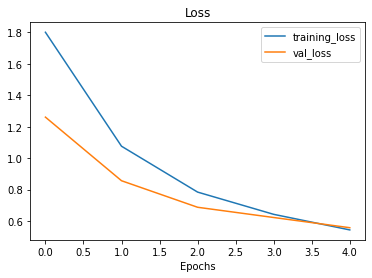

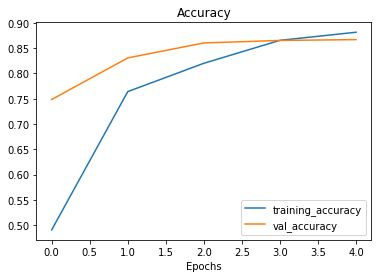

In [19]:
plot_loss_curves(history_0)